In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from mypackage import dir

# Environment variables
modality = 'u'
project = 'Ciencia de los datos'
data = dir.make_dir_line(modality, project) 
raw = data('raw')
processed = data('processed')

def cargar_datos(table_name: str) -> pd.DataFrame:
    df = pd.read_parquet(processed / f'{table_name}.parquet.gzip')
    print(f'Loaded table: {table_name}')
    return df

In [74]:
# Crear los rangos de edad
bins = [0, 9, 19, 29, 39, 49, 59, 69, 79, 89, 99, float('inf')]
labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99', '100+']

In [4]:
provincias = cargar_datos('provincias')
provincias.head()

Loaded table: provincias


,COD_PROV,DEN_PROV,itter107
0,1,Torino,ITC11
1,2,Vercelli,ITC12
2,3,Novara,ITC15
3,4,Cuneo,ITC16
4,5,Asti,ITC17


In [50]:
censo_tranformado = cargar_datos('censo_tranformado')
censo_tranformado.head()

Loaded table: censo_tranformado


,itter107,territory,sexistat1,gender,age,statciv2,marital_status,value
0,IT,Italy,1,males,0,1,never married,195688
2,IT,Italy,2,females,0,1,never married,184942
6,ITC,Nord-ovest,1,males,0,1,never married,51672
8,ITC,Nord-ovest,2,females,0,1,never married,48501
12,ITC1,Piemonte,1,males,0,1,never married,12987


In [51]:
censo_tranformado.shape, provincias.shape

((163350, 8), (107, 3))

In [83]:
df = censo_tranformado.merge(provincias, on = ['itter107'])
df = df.loc[:,['sexistat1','age','value']]
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)
df = df.groupby(['sexistat1','age_group'], observed=False)['value'].sum().reset_index()
df.head()

,sexistat1,age_group,value
0,1,0-9,2020762
1,1,10-19,2881302
2,1,20-29,3116150
3,1,30-39,3304452
4,1,40-49,3900875


In [85]:
df_piramide = df.pivot(index='age_group', columns='sexistat1', values='value').reset_index()
df_piramide.columns = ['age_group', 'men', 'women']
df_piramide['men'] = df_piramide['men']*(-1)
df_piramide.head()

,age_group,men,women
0,0-9,-2020762,1909999
1,10-19,-2881302,2701875
2,20-29,-3116150,2832834
3,30-39,-3304452,3181479
4,40-49,-3900875,3904334


In [176]:
bar_config = {
    'hoverinfo': 'x+y',
    'hovertemplate': '%{x:,.0f}<extra>%{y}</extra>'
}

# Crear la figura
fig = go.Figure()

# Agregar las barras para los hombres
fig.add_trace(go.Bar(
    y=df_piramide['age_group'],
    x=df_piramide['men'],
    **bar_config,
    orientation='h',
    name='Men',
    #marker=dict(color='blue')
))

# Agregar las barras para las mujeres
fig.add_trace(go.Bar(
    y=df_piramide['age_group'],
    x=df_piramide['women'],
    **bar_config,
    orientation='h',
    name='Women',
    #marker=dict(color='pink')
))


# Configurar el diseño de la figura
fig.update_layout(
    title='Pirámide Poblacional',
    xaxis_title='Población',
    yaxis_title='Grupo de edad',
    barmode='overlay',
    bargap=0.1,
    bargroupgap=0.1,
    yaxis=dict(
        tickmode='array',
        tickvals=np.arange(len(df_piramide['age_group'])),
        ticktext=df_piramide['age_group'],
        autorange='reversed'
    ),
)

fig.update_layout(

    xaxis=dict(
        title='Población',
        tickvals=list(range(-max(df_piramide['men'].max(), df_piramide['women'].max(), 
                             max(df_piramide['men'].max()//5, df_piramide['women'].max()//5, 1)))),
        ticktext=[f'{abs(x):,}' for x in range(-max(df_piramide['men'].max(), df_piramide['women'].max(), 
                                                max(df_piramide['men'].max()//5, df_piramide['women'].max()//5, 1)))],
        title_standoff=10
    ),

    yaxis=dict(
        title='Grupo de edad',
        tickmode='array',
        tickvals=np.arange(len(df_piramide['age_group'])),
        ticktext=df_piramide['age_group'],
        autorange='reversed',
        title_standoff=10
    ),

    barmode='overlay',
    bargap=0.1,
    plot_bgcolor='white',
    hovermode='y unified',
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='center',
        x=0.5
    ),
    
    margin=dict(l=100, r=100, t=80, b=80), 
    
)

fig.update_yaxes(autorange=True)

fig.show()

In [191]:
bar_config = {
    'hoverinfo': 'x+y',
    'hovertemplate': '%{x:,.0f}<extra>%{y}</extra>'
}

# Crear la figura
fig = go.Figure()

# Agregar las barras para los hombres (usamos valores absolutos para mostrar)
fig.add_trace(go.Bar(
    y=df_piramide['age_group'],
    x=-abs(df_piramide['men']),  # Mantenemos el negativo para posición pero usamos abs
    **bar_config,
    orientation='h',
    name='Men',
    #marker=dict(color='blue')
))

# Agregar las barras para las mujeres
fig.add_trace(go.Bar(
    y=df_piramide['age_group'],
    x=df_piramide['women'],
    **bar_config,
    orientation='h',
    name='Women',
    #marker=dict(color='pink')
))

# Configurar el diseño de la figura
max_value = max(abs(df_piramide['men']).max(), df_piramide['women'].max())
tick_step = max(max_value // 5, 1)  # Asegurar que el paso sea al menos 1

fig.update_layout(
    title='Pirámide Poblacional',
    yaxis_title='Grupo de edad',
    barmode='overlay',
    bargap=0.1,
    bargroupgap=0.1,
    yaxis=dict(
        tickmode='array',
        tickvals=np.arange(len(df_piramide['age_group'])),
        ticktext=df_piramide['age_group'],
        autorange='reversed'
    ),
    xaxis=dict(
        title='Población',
        tickvals=np.arange(-max_value, max_value + tick_step, tick_step),
        ticktext=[f'{abs(x):,}' for x in np.arange(-max_value, max_value + tick_step, tick_step)],
        title_standoff=10
    ),
    plot_bgcolor='white',
    hovermode='y unified',
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='center',
        x=0.5
    ),
    margin=dict(l=100, r=100, t=80, b=80), 
)

fig.update_yaxes(autorange=True)

fig.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_9788\270034284.py:45: UserWarning:

FixedFormatter should only be used together with FixedLocator



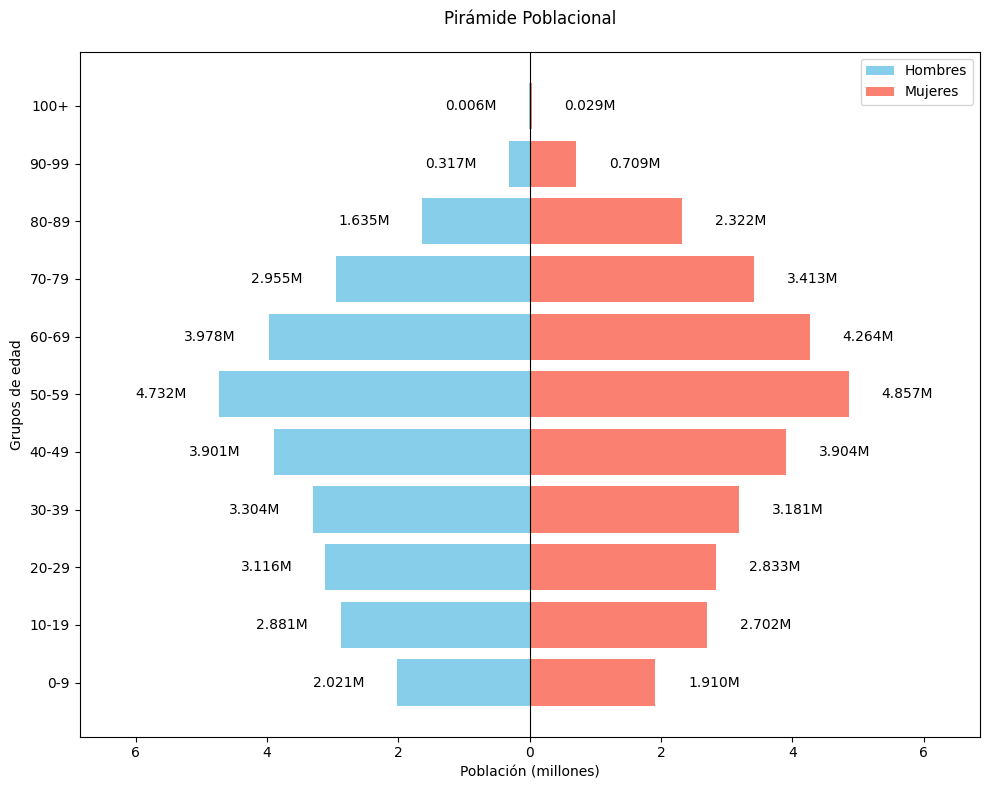

In [190]:
# Datos de ejemplo (población por edad y género)
edades = df_piramide['age_group']
hombres = (df_piramide['men'] * (-1)) / 1000000
mujeres = (df_piramide['women']) / 1000000


# Convertir a numpy arrays y valores negativos para hombres (para el efecto pirámide)
hombres = -np.array(hombres)
mujeres = np.array(mujeres)

# Crear la figura
fig, ax = plt.subplots(figsize=(10, 8))

# Crear las barras
bar_hombres = ax.barh(edades, hombres, color='skyblue', label='Hombres')
bar_mujeres = ax.barh(edades, mujeres, color='salmon', label='Mujeres')

# Añadir etiquetas con los valores absolutos
for bar in bar_hombres:
    width = bar.get_width()
    if width < 0:
        ax.text(width - 0.5, bar.get_y() + bar.get_height()/2, 
                f'{-width:.3f}M', 
                va='center', ha='right', color='black')

for bar in bar_mujeres:
    width = bar.get_width()
    if width > 0:
        ax.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}M', 
                va='center', ha='left', color='black')
        
# Personalizar el gráfico
ax.set_title('Pirámide Poblacional', pad=20)
ax.set_xlabel('Población (millones)')
ax.set_ylabel('Grupos de edad')
ax.legend()

# Ajustar los límites del eje x
max_val = max(max(-hombres), max(mujeres))
ax.set_xlim(-max_val - 2, max_val + 2)

# Mostrar el eje x con valores positivos
xticks = ax.get_xticks()
ax.set_xticklabels([f'{abs(x):.0f}' for x in xticks])

# Añadir línea vertical en cero
ax.axvline(0, color='black', linewidth=0.8)

# Mostrar el gráfico
plt.tight_layout()
plt.show()